# Data Loading: TensorFlow TFRecord

## Overview

This example shows you how to use the data that is stored in the TensorFlow TFRecord format with DALI.

## Creating index

To use data that is stored in the TFRecord format, we need to use the `readers.TFRecord` operator. In addition to the arguments that are common to all readers, such as `random_shuffle`, this operator takes `path`, `index_path` and `features` arguments.

* `path` is a list of paths to the TFRecord files
* `index_path` is a list that contains the paths to index files, which are used by DALI mainly to properly shard the dataset between multiple workers. The index for a TFRecord file can be obtained from that file by using the `tfrecord2idx` utility that is included with DALI. You need to create the index file only once per TFRecord file.
* `features` is a dictionary of pairs (name, feature), where feature (of type `dali.tfrecord.Feature`) describes the contents of the TFRecord. DALI features closely follow the TensorFlow types `tf.FixedLenFeature` and `tf.VarLenFeature`.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
import os
from pathlib import Path
from subprocess import call

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import nvidia.dali.experimental.dynamic as ndd
import nvidia.dali.tfrecord as tfrec

dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
tfrecord = dali_extra_dir / "db" / "tfrecord" / "train"
batch_size = 16
tfrecord_idx = Path("idx_files/train.idx")
tfrecord2idx_script = "tfrecord2idx"

if not tfrecord_idx.parent.exists():
    tfrecord_idx.parent.mkdir()

if not tfrecord_idx.is_file():
    call([tfrecord2idx_script, str(tfrecord), str(tfrecord_idx)])

## Defining and Running the Pipeline

1. Define a simple pipeline that takes the images stored in TFRecord format, decodes them, and prepares them for ingestion in DL framework.

   Processing images involves cropping, normalizing, and `HWC` -> `CHW` conversion process.

The TFRecord file that we used in this example does not have images upscaled to a common size. This results in an error during cropping, when the image is smaller than the crop window. To overcome this issue, use the `resize` operation before you crop. This step ensures that the shorter side of images being cropped is 256 pixels.

In [2]:
reader = ndd.readers.TFRecord(
    path=str(tfrecord),
    index_path=str(tfrecord_idx),
    features={
        "image/encoded": tfrec.FixedLenFeature((), tfrec.string, ""),
        "image/class/label": tfrec.FixedLenFeature([1], tfrec.int64, -1),
        "image/class/text": tfrec.FixedLenFeature([], tfrec.string, ""),
        "image/object/bbox/xmin": tfrec.VarLenFeature(tfrec.float32, 0.0),
        "image/object/bbox/ymin": tfrec.VarLenFeature(tfrec.float32, 0.0),
        "image/object/bbox/xmax": tfrec.VarLenFeature(tfrec.float32, 0.0),
        "image/object/bbox/ymax": tfrec.VarLenFeature(tfrec.float32, 0.0),
    },
)

for data in reader.next_epoch(batch_size=batch_size):
    jpegs = data["image/encoded"]
    images = ndd.decoders.image(jpegs, device="gpu")
    resized = ndd.resize(images, resize_shorter=256.0)
    output = ndd.crop_mirror_normalize(
        resized,
        dtype=ndd.float32,
        crop=(224, 224),
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
    )
    labels = data["image/class/text"]
    break  # Run once

2. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output of the pipeline is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
3. For the visualization purposes, transpose the images back to the `HWC` layout.

In [3]:
def show_images(image_batch: ndd.Batch, label_batch: ndd.Batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(20, (20 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j, (img, label) in enumerate(zip(image_batch, label_batch)):
        plt.subplot(gs[j])
        plt.axis("off")
        ascii_data = np.asarray(label)
        plt.title("".join([chr(item) for item in ascii_data]))
        img_chw = np.asarray(img.cpu())
        img_hwc = np.transpose(img_chw, (1, 2, 0)) / 255.0
        plt.imshow(img_hwc)
    plt.show()

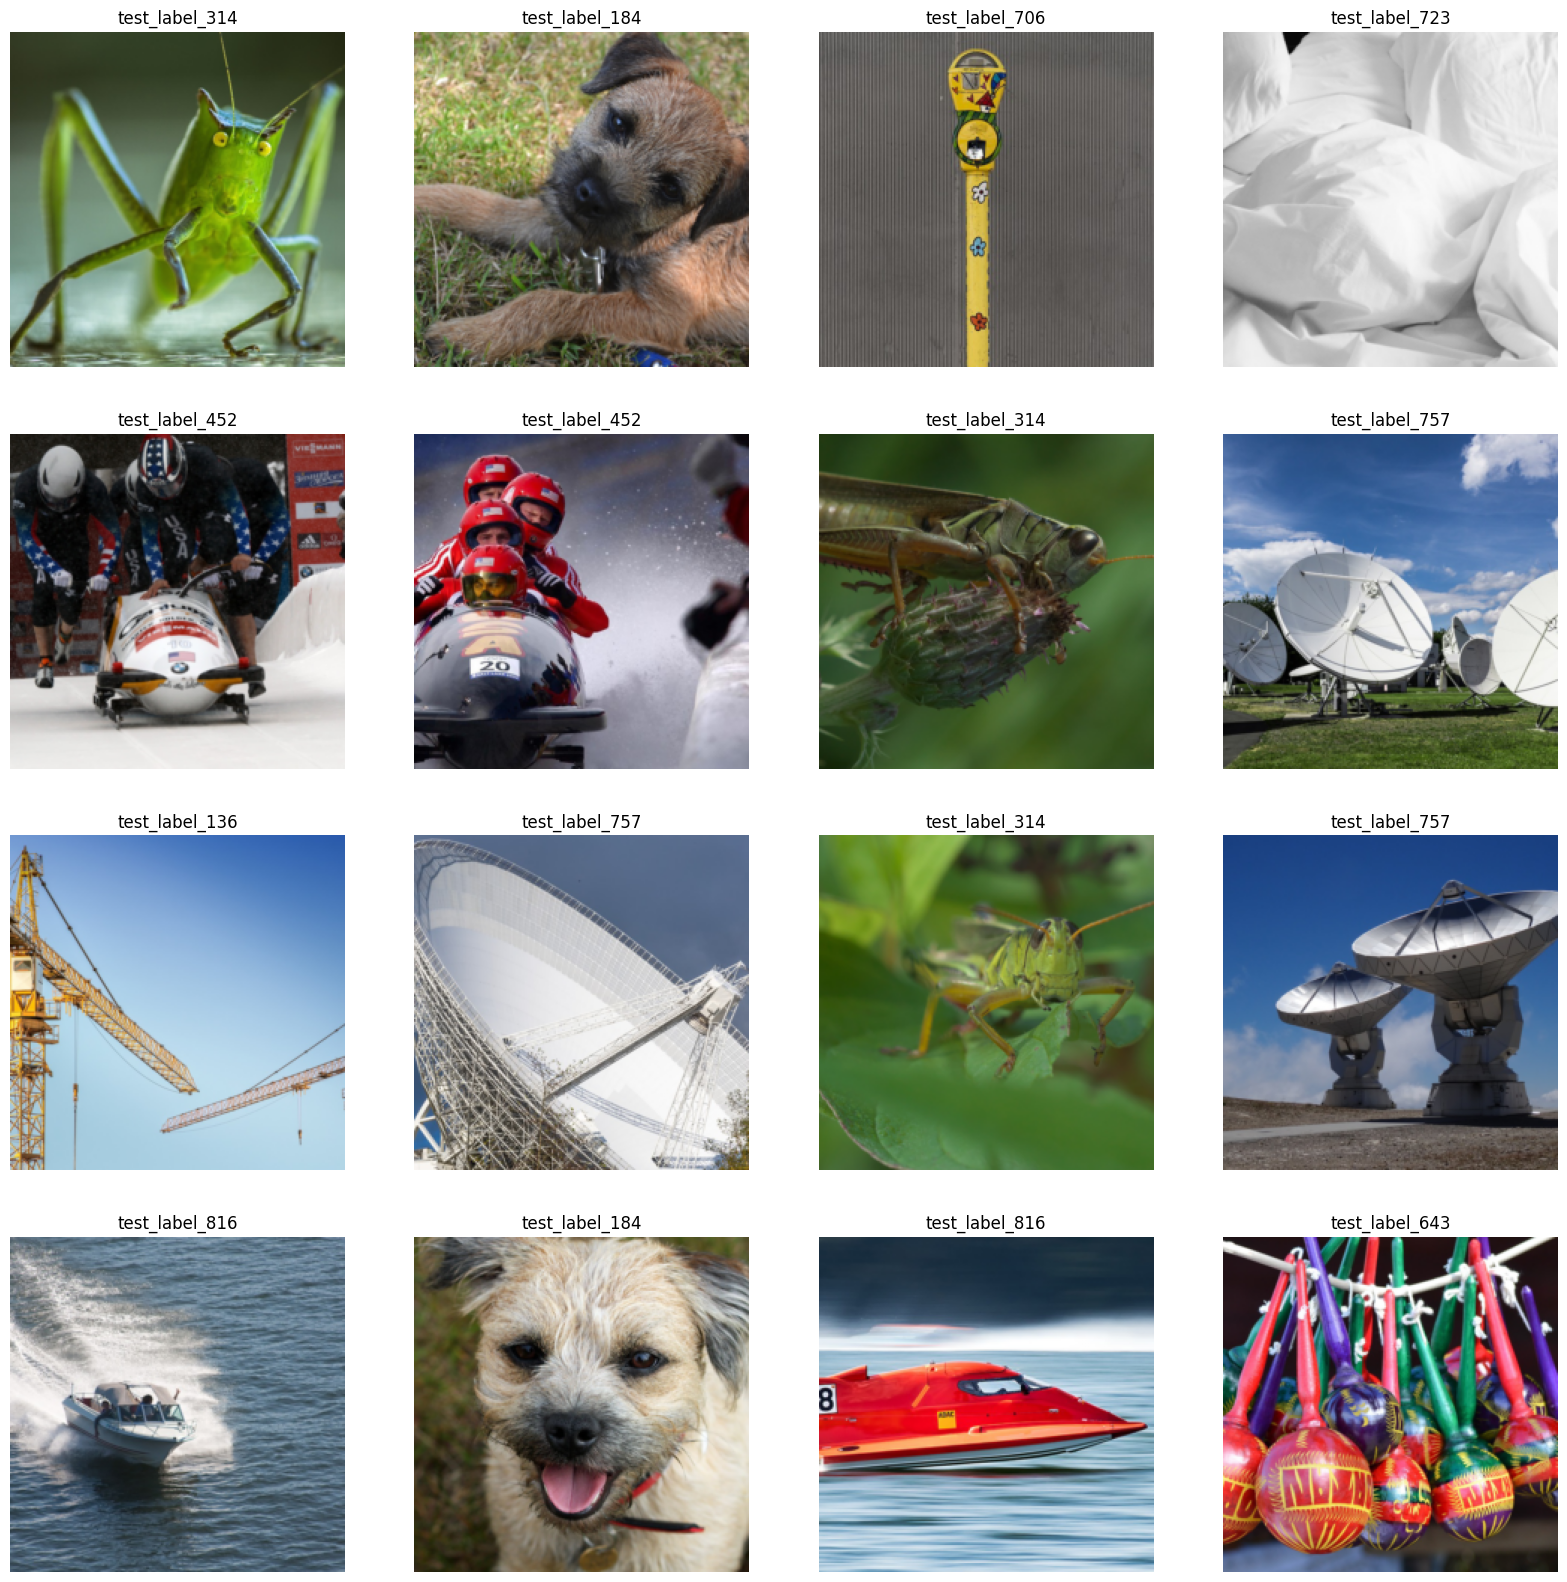

In [4]:
show_images(output, labels)

For more flexibility `VarLenFeature` supports the `partial_shape` parameter. If provided, the data will be reshaped to match its value. The first dimension will be inferred from the data size.